# Adjusting thrshold using validation set

In [1]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import pandas as pd
import pickle
import numpy as np
import sys
import os

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [7]:
from utils import plot_ROC
from adaptive_sv_system.utils import cos_dist_sim_torch, euc_dist_sim

In [12]:
f_sim = 'cos'
embeds = np.load('xvector_embeds/sv_embeds.npy')

Train Accuracy: 0.9320381628722325 
Train AUC: 0.9362077392691408 
Train Confusion Matrix:
[[ 82474   4302]
 [ 12388 146415]]


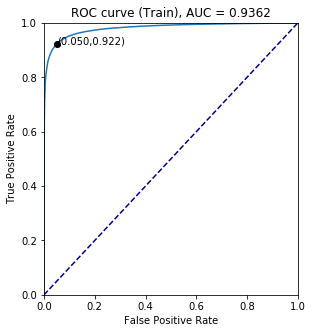

In [16]:
# trial for finding best threshold
trial_for_thresh = pd.read_pickle("trials/enr306_closedset/trial_for_thresh.pkl")

if f_sim == 'cos':
    train_score_vector = cos_dist_sim_torch(embeds[trial_for_thresh.enrolment_id],
                                      embeds[trial_for_thresh.test_id], dim=1)
elif f_sim == 'euc':
    train_score_vector =  euc_dist_sim(embeds[trial_for_thresh.enrolment_id], 
                                       embeds[trial_for_thresh.test_id], dim=1)
    
train_label_vector = trial_for_thresh.label.tolist()
accept_thres, fpr_, tpr_, thres_ = plot_ROC(train_label_vector, train_score_vector)

In [17]:
fnr_ = 1 - tpr_

In [22]:
fnr_

array([9.99993703e-01, 9.99615876e-01, 9.99603282e-01, ...,
       6.29711026e-06, 0.00000000e+00, 0.00000000e+00])

In [29]:
thres_[np.where(fnr_ < 0.01)[0][0]]

0.46138534

## PLDA score 

In [2]:
from batch_sv_system import get_embeds
from utils import key2df, df2dict, compute_eer, get_id2idx
from ioffe_plda.verifier import Verifier

In [3]:
trials = pd.read_pickle("trials/dev940_eval311/dev_original_trials.pkl")

embed_dir = "embeddings/voxc2_fbank64_voxc2untied_xvector/"
sv_embeds = np.load(embed_dir+"ln_lda_sv_embeds.npy")
sv_keys = pickle.load(open(embed_dir + "/sv_keys.pkl", "rb"))
sv_id2idx = get_id2idx(sv_keys)

py_plda_model = Verifier()
py_plda_model = Verifier(pickle.load(open("py_plda_model_ln_lda.pkl", "rb")))

In [4]:
dev_trial_ids = trials.groupby('enr_id', group_keys=False).apply(
    lambda x: list(x.test_id)).to_dict()
dev_trial_labels = trials.groupby('enr_id', group_keys=False).apply(
    lambda x: list(x.label)).to_dict()

In [5]:
from tqdm import tqdm
dev_scores = []
dev_labels = []
for (k, v), labels in tqdm(zip(dev_trial_ids.items(), dev_trial_labels.values()), 
                       total=len(dev_trial_ids)):
    enr_embeds = get_embeds([k], sv_embeds, sv_id2idx, norm=False)
    test_embeds = get_embeds(v, sv_embeds, sv_id2idx, norm=False)
    dev_scores += py_plda_model.score_avg(enr_embeds, test_embeds).mean(0).tolist()
    dev_labels += labels

100%|██████████| 78658/78658 [34:36<00:00, 37.89it/s]


In [10]:
dev_scores = np.array(dev_scores)
dev_labels = np.array(dev_labels)
dev_score_labels = np.stack([dev_scores, dev_labels], axis=1)
np.save("trials/dev940_eval311/dev_original_score_labels.npy", dev_score_labels)

In [24]:
from batch_sv_system import compute_minDCF
compute_minDCF(dev_scores, dev_labels, p_tar=0.9, c_miss=1, c_fa=1)

(0.19568278296632538, -11.4982)

## Score distribution 

In [94]:
from sklearn.mixture import GaussianMixture as gaussian

target_score_model = gaussian(n_components=12, init_params='random')
target_score_model.fit(dev_scores[dev_labels==1].reshape(-1, 1))

imp_score_model = gaussian(n_components=12, init_params='random')
imp_score_model.fit(dev_scores[dev_labels==0].reshape(-1, 1))

GaussianMixture(covariance_type='full', init_params='random', max_iter=100,
        means_init=None, n_components=12, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [95]:
cond_tar = target_score_model.score_samples(dev_scores[dev_labels==1].reshape(-1, 1))
cond_imp = imp_score_model.score_samples(dev_scores[dev_labels==1].reshape(-1, 1))
tar_probs = np.exp(cond_tar - np.logaddexp(cond_tar, cond_imp))

In [96]:
cond_tar = target_score_model.score_samples(dev_scores[dev_labels==0].reshape(-1, 1))
cond_imp = imp_score_model.score_samples(dev_scores[dev_labels==0].reshape(-1, 1))
tar_probs = np.exp(cond_tar - np.logaddexp(cond_tar, cond_imp))

In [ ]:
np.sort(tar_probs)[-1000:]

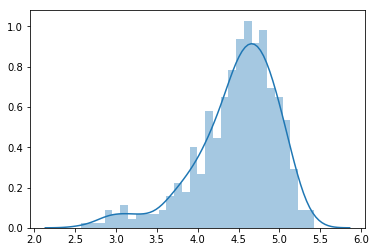

In [775]:
import seaborn as sns
sns.distplot(norm_score_fusions[test_trial[1]==1], bins=30, kde=True)

## Dev target trial 

In [ ]:
dev_target_trials = pickle.load(open("trials/dev940_eval311/dev_target_trials.pkl", "rb"))

dev_trial_keys = list(dev_target_trials.keys())

dev_target_scores = []
for k, v in tqdm(dev_target_trials.items(), total=len(dev_target_trials)):
    enr_embeds = get_embeds([k], sv_embeds,  sv_id2idx, norm=False)
    test_embeds = get_embeds(v, sv_embeds,  sv_id2idx, norm=False)
    dev_target_scores += py_plda_model.multi_sess(enr_embeds, test_embeds, cov_scaling=False, cov_adapt=False).mean(0).tolist()

pickle.dump(dev_target_scores, open("trials/dev940_eval311/dev_target_score.pkl", "wb"))